In [ ]:
!pip install langdetect
!pip install tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langdetect import detect



# Initial Data Processing
## Train data = Unsupervised data
The preprocessing begins by loading `train_data` from `data_unsupervised.csv`. Duplicate entries are removed to ensure data uniqueness.


In [ ]:
data_unsupervised_path = '/content/drive/MyDrive/reddit/data_unsupervised.csv'

train_data = pd.read_csv(data_unsupervised_path, encoding="utf8")
train_data = train_data.drop_duplicates()
train_data.reset_index(drop=True, inplace=True)


In [ ]:
train_data.tail()


Subsequently, if empty fields are detected, they are dropped.


In [ ]:
train_data = train_data.dropna()



## Language Detection and Text Processing

In the preprocessing pipeline, each comment's language is identified, filtering out non-English comments to focus the analysis on English ones. English comments are then normalized (converted to lowercase), lemmatized, and stripped of stop words using spaCy, thus refining the text for effective feature extraction.



In [ ]:
import pickle
with open('languages.pkl', 'rb') as file:
    languages = pickle.load(file)

with open('errors_rows.pkl', 'rb') as file:
    errors_rows = pickle.load(file)


In [ ]:
english_comments = languages.count('en')
total_comments = len(languages)

In [ ]:
train_data['language'] = languages
train_data_en = train_data[train_data['language'] == 'en']


In [ ]:
train_data_en['body'] = train_data_en['body'].str.lower()
train_data_en.shape

In [ ]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
from sklearn.utils import shuffle

# Load spaCy's English language model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function to preprocess text: remove stop words and lemmatize (reduce to root or bas form)
def preprocess_text(texts):
    processed_texts = []
    for doc in nlp.pipe(texts):
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        processed_texts.append(tokens)  # Append the list of tokens
    return processed_texts

# apply to comments
train_data_en['body'] = preprocess_text(train_data_en['body'])

## Language Models exploration

In this segment, transfer learning is applied using the pre-trained language model **Doc2Vec**. `tagged_data` iterates through the comments in the 'body' column of the `train_data_en` DataFrame, assigns a unique tag (the index 'i') to each comment, and creates a TaggedDocument instance for each comment with its corresponding tag and the tokenized words.
Following this, the model is initialized, its vocabulary is constructed, and the model is subjected to training.

In [ ]:
from gensim.models.doc2vec import TaggedDocument

tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(train_data_en['body'])]

from gensim.models import Doc2Vec


start_alpha = 0.025
end_alpha = 0.0001
model = Doc2Vec(vector_size=200, window=10, min_count=5, workers=4, alpha=start_alpha, min_alpha=end_alpha)

model.build_vocab(tagged_data)

# Train
for epoch in range(30):
    print('iteration {0}'.format(epoch))
    model.alpha = start_alpha - (start_alpha - end_alpha) * (epoch / 10)
    model.min_alpha = model.alpha
    model.train(tagged_data, total_examples=model.corpus_count, epochs=1)

model.save("doc2vec_model")



## Supervised Data

Now the supervised data is subjected to preprocessing as in Section 1. This is a key process for the upcoming actions: *Feature extraction* and *Dimensionality reduction*

In [ ]:
supervised_data = pd.read_csv('/content/drive/MyDrive/reddit/data_supervised.csv', encoding="utf8")
supervised_data = supervised_data.drop_duplicates()
supervised_data.reset_index(drop=True, inplace=True)

target = pd.read_csv("/content/drive/MyDrive/reddit/target_supervised.csv")
target=target.drop_duplicates()
target.reset_index(drop=True,inplace=True)

print(supervised_data.tail())
print(target.head())

supervised_data['language'] = languages
supervised_data_en = supervised_data[supervised_data['language'] == 'en']
supervised_data_en['body'] = supervised_data_en['body'].str.lower()

supervised_data_en['body'] = preprocess_text(supervised_data_en['body'])




## Feature Extraction and Vectorization

1.   The unique subreddits are extracted and a numerical mapping is created.
This mapping is used later to convert subreddit names into numerical format.
2.   The function `extract_features` takes a group of data associated with a specific author and extracts features related to their subreddit activities.
For each author, a binary vector is created, indicating the subreddits they have commented in. Each position in the vector corresponds to a subreddit, and it is marked as 1 if the author has commented in that subreddit.
The function utilizes a sparse matrix `v` to efficiently represent the binary vector.
3.   We group the `supervised_data_en` by author and apply the function `extract_features`. This results is a dictionary where each author's identifier is associated with their corresponding sparse matrix representing subreddit activity.
4.       The final step involves combining the individual author features into a single sparse matrix named X. This matrix represents the subreddit features for all authors in the dataset.
The combination is achieved by vertically stacking the sparse matrices corresponding to each author's subreddit activity.





In [ ]:
# Feature Extraction Process

# 1. Extracting unique subreddits and creating a numerical mapping:
subreddits = supervised_data.subreddit.unique()
subreddits_map = pd.Series(index=subreddits, data=np.arange(subreddits.shape[0]))

# 2. Function to extract subreddit features for each author:
from scipy import sparse
def extract_features(group):
    group_subreddits = group['subreddit']
    group_subreddits = group_subreddits[group_subreddits.isin(subreddits_map.index)].values
    idxs = subreddits_map.loc[group_subreddits].values
    v = sparse.dok_matrix((1, subreddits.shape[0]))
    for idx in idxs:
        if not np.isnan(idx):
            v[0, idx] = 1
    return v.tocsr()

# 3. Building feature vectors for each author
features_dict = {}
for author in target['author']:
    group = supervised_data_en[supervised_data_en['author'] == author]
    features_dict[author] = extract_features(group)

# 4. Combining individual author features into a single matrix
# This matrix, X, contains the subreddit features for all authors in the dataset.
X = sparse.vstack([features_dict[author] for author in target['author']])





In this step, for each author, the code aggregates all the tokens from the 'body' column into a single list named `aggregated_tokens`. After consolidating tokens for each author, a list named `author_text` is generated to hold the collected words for each author in the *target* dataset.

In [ ]:
text_dict = {}
for author, group in supervised_data.groupby('author'):
    aggregated_tokens = []
    for text in group['body']:
        aggregated_tokens.extend(text)  # Append tokens to the list
    text_dict[author] = aggregated_tokens



author_text = [text_dict[author] for author in target.author]


## Dimensionality Reduction with Truncated SVD

To handle the large number of features, we apply Truncated Singular Value Decomposition (SVD) to the sparse matrix `X`, which contains the subreddit features for all authors in the dataset. After reducing the dimensions, we compute and display the cumulative explained variance. This metric quantifies how much information is retained in the reduced dataset, helping assess the effectiveness of dimensionality reduction.


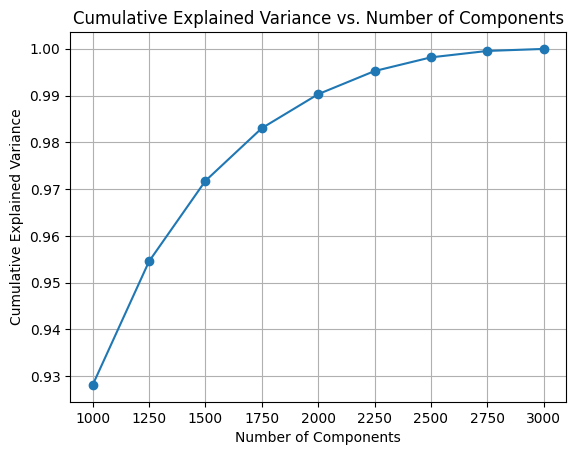

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt



n_components=1500
svd = TruncatedSVD(n_components=n_components)
user_subreddit_svd = svd.fit_transform(X)

# Calculate cumulative explained variance
explained_variances = svd.explained_variance_ratio_


# Plot the cumulative explained variance
plt.plot(range(1,n_components+1), explained_variances.cumsum(), marker=None)
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [ ]:
n_components = 1000
svd = TruncatedSVD(n_components=n_components)
X_reduced = svd.fit_transform(X)
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Cumulative explained variance for {n_components} components: {explained_variance}")


Cumulative explained variance for 1000 components: 0.9281272066029572


# Concatenation of feature vectors
Now we must combine the features obtained from two different sources: the reduced subreddit features (from Truncated SVD) and the Doc2Vec features.


1.   For each author in the target dataset, we use the pre-trained mdoel to infer a numerical vector representation (infer_vector) based on the aggregated tokens associated with that author.
The resulting vectors are collected into a NumPy array named `doc2vec_features`.
2.   `X_reduced`  contains the reduced subreddit features obtained after applying Truncated SVD.
Using np.hstack, we horizontally stack the reduced subreddit features and the Doc2Vec features.
The result is a new feature matrix named `X_final`.


In [ ]:
doc2vec_features = np.array([model.infer_vector(text_dict[author]) for author in target['author']])

In [ ]:

X_final = np.hstack([X_reduced, doc2vec_features])

In [ ]:
X_final.shape

(5000, 2000)



In this code, SMOTE is applied to the combined feature matrix (`X_final`) along with the corresponding gender labels (`target['gender']`). This step contributes to addressing the imbalance in the dataset (as in Section 1), ensuring a more equitable representation of different gender classes in the training data.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_final, target['gender'])


# Model training
This section involves training the model on the supervised over-sampled data, with the aim of fine tuning the last layer of the network.
The neural network architecture, implemented using TensorFlow and Keras libraries, consists of the following components:

- A dense input layer featuring 128 neurons, employing the ReLU activation function.
- An output layer with a single neuron utilizing the sigmoid activation function, designed for binary classification.

For optimization, the Adam optimizer with a learning rate of 0.0001 was selected. The model was compiled with binary cross-entropy loss and binary accuracy as evaluation metrics.

The data was divided into training (70%) and validation (30%) sets. The model underwent 100 training epochs, utilizing both datasets for iterative learning and performance assessment.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



model_final = Sequential()
model_final.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model_final.add(Dense(1, activation='sigmoid'))

adam=tf.keras.optimizers.Adam(learning_rate=0.0001)
model_final.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy'])


history = model_final.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))


## Optimal stopping point
To prevent overfitting and determine the optimal stopping point, we monitored the validation loss throughout the training process. The marked point on the plot corresponds to the epoch with the minimum validation loss, which is identified as the optimal stopping point for training. In both accuracy and loss plots, the red marker indicates the epoch where the model achieves the best performance on the validation dataset.

In [ ]:
import matplotlib.pyplot as plt


val_loss = history.history['val_loss']
min_val_loss_index = np.argmin(val_loss)
min_val_loss_epoch = min_val_loss_index + 1
min_val_loss_value = val_loss[min_val_loss_index]

epoch_to_mark = min_val_loss_index

y_offset = 0.02


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.scatter(epoch_to_mark, history.history['val_binary_accuracy'][epoch_to_mark], color='red')  # Mark on the plot
plt.text(epoch_to_mark-1, history.history['val_binary_accuracy'][epoch_to_mark]+y_offset, f' Epoch {epoch_to_mark + 1}', color='black')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

y_offset = 0.04

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.scatter(epoch_to_mark, history.history['val_loss'][epoch_to_mark], color='red')  # Mark on the plot
plt.text(epoch_to_mark-1, history.history['val_loss'][epoch_to_mark]+y_offset, f' Epoch {epoch_to_mark + 1}', color='black')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()